### Documentation: https://numpy.org/doc/stable/reference/index.html , https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html, https://docs.python.org/3/library/random.html

#### Instructions: This code generates diffusive trajectories that represent a folding of a protein.
#### Problema atual: Dependência da variável NG 

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [14]:

## Loading the input data ##

vl = np.genfromtxt("/home/vitor/UFTM/Iniciação/TuningDiffusion/input_data/data_sin.txt", dtype= None, delimiter= None)

# Update file path according to user

# print(vl, type(vl))

In [15]:
## Defining the variables and supplying them with data ##

X = vl[0]

DIFFX = vl[1]

SINM = vl[2] ##  um2/s

SINF=vl[3] ##  um2/s

STEPS = vl[4] ## 100.000.000.000 ##

dt = vl[5]

basin1 = vl[6] 
basin2 = vl[7]

HEIGHT = vl[8]

SLOPE = vl[9]

NG = vl[10]

#print(X, DIFFX, SINM, SINF, STEPS, dt, basin1, basin2, HEIGHT, SLOPE, NG)

In [16]:
## 

M=(basin2+basin1)/2
D=(basin2-basin1)/2

bounds = 100
grids = 100000
width = bounds*1.000000/grids

# print(M, D, width)

In [17]:
## Checking the values of the loaded data ##

for l in vl:
    print(l)

30.0
1.5
1.0
4.0
100000000.0
0.01
22.0
47.0
3.6
-0.03
2.0
27.0
2.3
-1.0
40.0
4.0
-2.0


In [6]:
### 

Max = np.array([0,0])
sigma = np.array([0,0])
GH = np.array([0,0])

for i in range(int(NG)):
    j = i*3 
    Max[i] = vl[11+j] # The array takes the value of the reference plus three times ahead
    sigma[i] = vl[12+j]
    GH[i] = vl[13+j]
    
# print(Max)
# print(sigma)
# print(GH)    

In [7]:
###

def DD(DIFFX, SINM, X, SINF):
    eqd = DIFFX+SINM*np.sin(X/SINF)
    return eqd

def DDslope(DIFFX, SINM, X, SINF):
    eqs = SINM/SINF*np.cos(X/SINF)
    return eqs

def grad24(M, D, HEIGHT, X):
    eq1 = (-2*HEIGHT*2*(X-M)/D**2 +4*HEIGHT*(X-M)**3/D**4)
    return eq1

def E24(M, D, HEIGHT, X):
    eq2 = (-HEIGHT*2*(X-M)**2/D**2 +HEIGHT*(X-M)**4/D**4)
    return eq2
    
def gradG(Max, sigma, HEIGHT, X):
    #Sg = [l**2 for l in sigma]
    eq3 = HEIGHT*np.exp(-(X-Max)**2/sigma**2)*2*(Max-X)/sigma**2 
    return eq3
    
def EG(Max, sigma, HEIGHT, X):
    #Sg = [l**2 for l in sigma]
    eq4 = HEIGHT*np.exp(-(X-Max)**2/sigma**2)
    return eq4

 
#print(DD(DIFFX, SINM, X, SINF), DDslope(DIFFX, SINM, X, SINF), grad24(M, D, HEIGHT, X), E24(M, D, HEIGHT, X), gradG(Max, sigma, HEIGHT, X), EG(Max, sigma, HEIGHT, X))


In [8]:
###

def gaussian (DIFFX, dt):
    # sd is the rms value of the distribution.
    sd = 2*DIFFX*dt
    sd = np.sqrt(sd)
    RR = 0 
    while True:
        M1 = random.random()
        M2 = random.random()
        M1 = 2*(M1-0.5)
        M2 = 2*(M2-0.5)
        tmp1 = M1*M1 + M2*M2
        if tmp1 <= 1.0 and tmp1 >= 0.0:
            tmp2 = sd*np.sqrt( -2*np.log(tmp1)/tmp1 )
            RR = M1*tmp2
        if RR:
            break
    return RR

#print(gaussian(DIFFX, dt))

In [9]:
### Surface calculation ###

FF=[]
ES =[]
Hm = []
DDV = []
DDM=[]

for i in range(grids):
    H = i*width
    FX = 0
    EE = 0
    grad1 = grad24(M, D, HEIGHT, H)
    FX += grad1
    
    grad2 = E24(M,D,HEIGHT,H)
    EE += grad2
    
    for l in range(int(NG)):
        grad3 = gradG(Max[l], sigma[l], GH[l], H)
#         print(grad3)
        FX += grad3
        
        grad4 = EG(Max[l], sigma[l], GH[l], H)
        EE += grad4
    
    EE += SLOPE*H
    FX += SLOPE
    DDv = DD(DIFFX, SINM, H, SINF)
    DDm = DDslope(DIFFX, SINM, H, SINF)
    
    FF.append(FX)
    ES.append(EE)
    Hm.append(H)
    DDV.append(DDv)
    DDM.append(DDm)
    
FF = np.asarray(FF)
EE = np.asarray(ES)
DDV = np.asarray(DDV)
X = np.asarray(Hm)


np.savetxt('SURFACE_XS', X, fmt="%10.6f")
np.savetxt('SURFACE_EES', EE, fmt="%10.6f")
np.savetxt('SURFACE_FXS', FF, fmt="%10.6f")
np.savetxt('SURFACE_DDv', DDV, fmt="%10.6f")

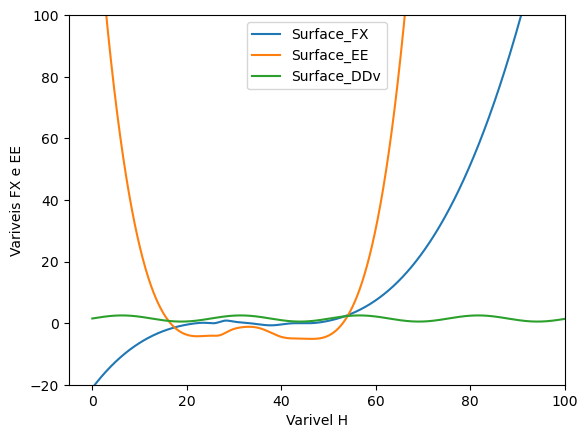

In [10]:
### Surface ###

x = X 
fig, ax = plt.subplots()
ax.plot(x, FF, label = 'Surface_FX') 
ax.plot(x, EE, label = 'Surface_EE')
ax.plot(x, DDV, label = 'Surface_DDv')
plt.xlabel('Varivel H')
plt.ylabel('Variveis FX e EE')
plt.xlim([None, 100])
plt.ylim([-20, 100])
plt.legend()
plt.show()

In [11]:
### Trajectory calculation ###
G = []
X = []

for i in range(int(STEPS)):
    
    J = int(H/width)
#    print(J)
    FX =FF[(J)]
    DX=DDV[(J)]
    Dslope=DDM[(J)]
#    print(FX)
    H += (Dslope-DX*FX)*dt+gaussian(DX,dt);
#    print(Gaussis)
    
    if i % 100==0:  ## spride ## every 100 values
        T = dt *i
        G.append(H)
        X.append(T)
    
X = np.asarray(X)
G = np.asarray(G)

np.savetxt('TRAJECTORY_YS', G, fmt="%5.2f" )
np.savetxt('TRAJECTORY_XS', X, fmt="%5.2f" )

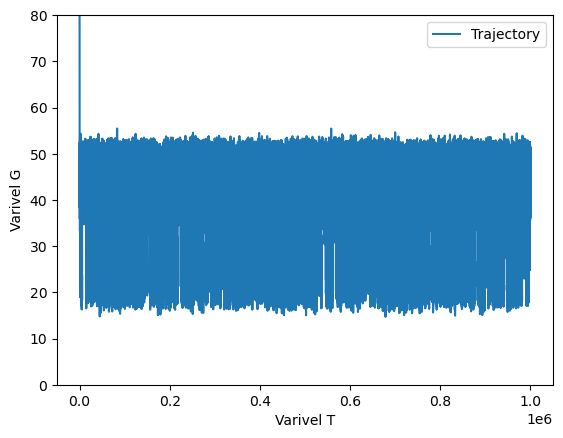

In [12]:
### Trajectory ###

x = X 
fig, ax = plt.subplots()
ax.plot(x, G, label = 'Trajectory')
plt.xlabel('Varivel T')
plt.ylabel('Varivel G')
# plt.xlim([None, 60])
plt.ylim([0, 80])
plt.legend()
plt.show()